In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import gc
import sys
from statsmodels.formula.api import ols
from IPython.display import clear_output
from numba import njit, jit

In [2]:
df = pd.read_csv('SALES_2019.csv', parse_dates=['Date'])

In [3]:
df

,SKU_ID,Store_ID,Date,Demand,Regular_Price
0,114,1078,2019-01-01,2.0,51.0
1,114,1078,2019-01-02,2.0,51.0
2,114,1078,2019-01-03,2.0,51.0
3,114,1078,2019-01-04,2.0,51.0
4,114,1078,2019-01-05,2.0,51.0
...,...,...,...,...,...
75549757,363971,2866,2019-12-25,2.0,104.0
75549758,363971,2866,2019-12-26,2.0,104.0
75549759,363971,2866,2019-12-27,2.0,104.0
75549760,363971,2866,2019-12-28,2.0,104.0


<AxesSubplot:xlabel='Date'>

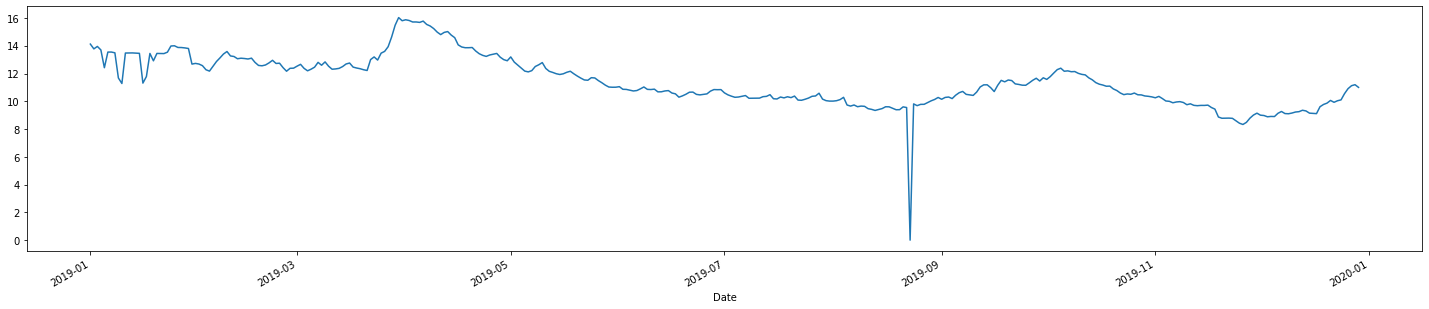

In [4]:
df.groupby('Date').mean()['Demand'].plot(figsize=(25, 5))

In [5]:
df = df[df.Demand > 0]
df

,SKU_ID,Store_ID,Date,Demand,Regular_Price
0,114,1078,2019-01-01,2.0,51.0
1,114,1078,2019-01-02,2.0,51.0
2,114,1078,2019-01-03,2.0,51.0
3,114,1078,2019-01-04,2.0,51.0
4,114,1078,2019-01-05,2.0,51.0
...,...,...,...,...,...
75549757,363971,2866,2019-12-25,2.0,104.0
75549758,363971,2866,2019-12-26,2.0,104.0
75549759,363971,2866,2019-12-27,2.0,104.0
75549760,363971,2866,2019-12-28,2.0,104.0


In [6]:
popular_pairs = df.groupby(['SKU_ID', 'Store_ID']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).reset_index(drop=True)

In [7]:
popular_pairs.head(n=10)

,SKU_ID,Store_ID,counts
0,121403,2834,361
1,14408,2834,361
2,150862,2834,361
3,213851,2834,361
4,93788,2834,361
5,137749,1855,361
6,149856,2676,361
7,93788,2711,361
8,4240,1498,361
9,93788,2710,361


In [8]:
popular_pairs.head(n=100000).tail(n=1)

,SKU_ID,Store_ID,counts
99999,23080,1504,340


In [9]:
num_of_pairs = 100000
pairs_for_experiment = [0 for _ in range(num_of_pairs)]
for i, r in popular_pairs.iterrows():
    if i == num_of_pairs:
        break
    pairs_for_experiment[i] = (r['SKU_ID'], r['Store_ID'])

In [10]:
def transform(x, ttype):
    '''
    Accepts vector and performs transformation on it based on ttype
    '''
    if ttype == 'log':
        return np.log1p(x)
    
    return np.array(x)

In [11]:
def coef(model):
    """
    return regression coefficient of model
    """
    return model.params[1] if len(model.params) > 1 else model.params[0]

def pvalue(model):
    """
    return regression coefficient's t-test p-value of model
    """
    return model.pvalues[1] if len(model.pvalues) > 1 else model.pvalues[0]

In [12]:
def elasticity(X, y, model, model_type):
    '''
    Computes elasticity of model based on X, y, model itself and model's type
    '''
    if model_type == 'lin-lin':
        return coef(model) * np.mean(X) / np.mean(y)
    elif model_type == 'log-lin':
        return coef(model) * np.mean(X)
    elif model_type == 'log-log':
        return coef(model)

In [13]:
def PEDmodel(X, y, model_type='lin-lin'):
    '''
    Makes PED model based on input data X, y and model type
    '''
    _types = model_type.split('-')
    
    act_x = transform(X, _types[1])
    act_x = sm.add_constant(act_x)
    
    act_y = transform(y, _types[0])
    
    return sm.OLS(act_y, act_x).fit()

In [14]:
def get_model_stats(X, y, model, model_type):
    '''
    returns model's statistics
        regression coefficient,
        R-squared,
        T-test p-value,
        elasticity
    '''
    elas = elasticity(X, y, model, model_type)
    
    return coef(model), model.rsquared, pvalue(model), elas

In [16]:
def GeneratePEDModels(dataset):
    model_type = 'log-log'
    sku_id, store_id, elas, qty, ttpvalue, price, q1_elas = [], [], [], [], [], [], []
    q1_ttp = []
    iter_count = 0

    for good_id, shop_id in pairs_for_experiment:
        data = dataset[(dataset.Store_ID == shop_id) & (dataset.SKU_ID == good_id)]
        model = PEDmodel(data.Regular_Price, data.Demand, model_type)
        
        c, r2, tp, e = get_model_stats(data.Regular_Price, data.Demand, model, model_type)

        sku_id.append(good_id)
        store_id.append(shop_id)
        elas.append(e)
        ttpvalue.append(tp)
        
        # 2019 Q1
        data = data[(data.Date >= '2019-01-01') & (data.Date <= '2019-03-31')]
        model = PEDmodel(data.Regular_Price, data.Demand, model_type)
        c, r2, tp, e = get_model_stats(data.Regular_Price, data.Demand, model, model_type)
        
        qty.append(data.Demand.sum() / data.shape[0])
        price.append(data.Regular_Price.sum() / data.shape[0])
        q1_elas.append(e)
        q1_ttp.append(tp)
        
        clear_output()
        print(iter_count)
        iter_count += 1
        
        if iter_count == 30000:
            break
        
    
    return pd.DataFrame({
        'SKU': sku_id,
        'Store': store_id,
        'Elasticity': elas,
        'P_value': ttpvalue,
        'Q1_Qty': qty,
        'Q1_Price': price,
        'Q1_Elasticity': q1_elas,
        'Q1_Ttest': q1_ttp
    })

In [17]:
trained_data = GeneratePEDModels(df)

29999


In [18]:
trained_data

,SKU,Store,Elasticity,P_value,Q1_Qty,Q1_Price,Q1_Elasticity,Q1_Ttest
0,121403,2834,4.947777e+00,1.387119e-91,203.211111,219.056926,2.499524e-01,4.107512e-01
1,14408,2834,-1.248910e+00,2.932442e-61,202.344444,60.457444,-3.693639e+00,6.597211e-08
2,150862,2834,-1.006074e+00,2.219744e-64,266.366667,301.042889,-1.490706e+00,1.388874e-14
3,213851,2834,-1.328601e+00,5.668468e-03,4141.500000,90.424887,-5.872169e-01,4.622280e-01
4,93788,2834,1.314355e+00,9.124566e-86,206.511111,495.959667,1.156394e+00,1.298470e-08
...,...,...,...,...,...,...,...,...
29995,2010,1104,8.609657e+00,1.382582e-10,2.930233,389.313953,3.194009e+00,2.108291e-01
29996,14978,2231,9.933930e-02,1.456373e-06,1.905882,281.152941,-7.351222e-02,7.006502e-01
29997,147136,2232,-1.346145e-15,9.605337e-01,1.000000,146.640449,7.771561e-15,9.683149e-01
29998,118617,1118,9.419250e-02,6.148370e-01,1.377778,283.422222,1.273333e+01,6.010513e-21


In [19]:
trained_data.to_csv('DF_TRAIN_.csv', index=False)

In [2]:
trained_data = pd.read_csv('DF_TRAIN_.csv')

In [20]:
df_train = trained_data[(trained_data.Elasticity > -10) & (trained_data.Elasticity < 0) & (trained_data.P_value < 0.05)]

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13620 entries, 1 to 29999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SKU            13620 non-null  int64  
 1   Store          13620 non-null  int64  
 2   Elasticity     13620 non-null  float64
 3   P_value        13620 non-null  float64
 4   Q1_Qty         13620 non-null  float64
 5   Q1_Price       13620 non-null  float64
 6   Q1_Elasticity  13620 non-null  float64
 7   Q1_Ttest       13620 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 957.7 KB


In [22]:
product_info = pd.read_csv('PRODUCT_INF.csv')

In [23]:
product_info

,ProductName,SKU,ClassId,GroupId,SubGroupId,CategoryId,ClusterId,Class,Groups,SubGroups,Category,Cluster
0,UN,9999999,-5,-4,-3,-2,-1,UN,UN,UN,UN,UN
1,Очки_x0020_корригирующие_x0020_Ocean_x0020_пла...,122139,-5,-4,-3,-2,-1,UN,UN,UN,UN,UN
2,Очки_x0020_корригирующие_x0020_Ocean_x0020_пла...,122140,-5,-4,-3,-2,-1,UN,UN,UN,UN,UN
3,Очки_x0020_корригирующие_x0020_Ocean_x0020_пла...,122141,-5,-4,-3,-2,-1,UN,UN,UN,UN,UN
4,Очки_x0020_корригирующие_x0020_Dali_x0020_плас...,122142,-5,-4,-3,-2,-1,UN,UN,UN,UN,UN
...,...,...,...,...,...,...,...,...,...,...,...,...
296388,Лактамил_x0020_смесь_x0020_сухая_x0020_молочна...,112785,2000,2010,2133,2915,834,Товары_x0020_для_x0020_матери_x0020_и_x0020_ре...,Товары_x0020_для_x0020_беременных_x0020_и_x002...,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам
296389,Чай_x0020__x0022_Хипп_x0022__x0020_с_x0020_вит...,112789,2000,2010,2133,2915,834,Товары_x0020_для_x0020_матери_x0020_и_x0020_ре...,Товары_x0020_для_x0020_беременных_x0020_и_x002...,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам
296390,Чай_x0020_Хипп_x0020_био_x0020_для_x0020_корм....,76810,2000,2010,2133,2915,834,Товары_x0020_для_x0020_матери_x0020_и_x0020_ре...,Товары_x0020_для_x0020_беременных_x0020_и_x002...,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам
296391,Фемилак_x0020_для_x0020_беременных_x0020_и_x00...,75619,2000,2010,2133,2915,834,Товары_x0020_для_x0020_матери_x0020_и_x0020_ре...,Товары_x0020_для_x0020_беременных_x0020_и_x002...,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам,Питание_x0020_для_x0020_мам


In [24]:
product_info = product_info[['SKU', 'ClassId', 'CategoryId', 'ClusterId', 'GroupId', 'SubGroupId']]

In [25]:
df_sku = df_train.join(product_info.set_index('SKU'), on='SKU')

In [26]:
df_sku.isna().sum()

SKU               0
Store             0
Elasticity        0
P_value           0
Q1_Qty            0
Q1_Price          0
Q1_Elasticity     0
Q1_Ttest          0
ClassId          55
CategoryId       55
ClusterId        55
GroupId          55
SubGroupId       55
dtype: int64

In [27]:
df_sku.dropna(inplace=True)

In [28]:
df_sku.isna().sum()

SKU              0
Store            0
Elasticity       0
P_value          0
Q1_Qty           0
Q1_Price         0
Q1_Elasticity    0
Q1_Ttest         0
ClassId          0
CategoryId       0
ClusterId        0
GroupId          0
SubGroupId       0
dtype: int64

In [29]:
df_sku

,SKU,Store,Elasticity,P_value,Q1_Qty,Q1_Price,Q1_Elasticity,Q1_Ttest,ClassId,CategoryId,ClusterId,GroupId,SubGroupId
1,14408,2834,-1.248910,2.932442e-61,202.344444,60.457444,-3.693639e+00,6.597211e-08,2003.0,2561.0,27.0,2047.0,2356.0
2,150862,2834,-1.006074,2.219744e-64,266.366667,301.042889,-1.490706e+00,1.388874e-14,2003.0,2547.0,4.0,2047.0,2099.0
3,213851,2834,-1.328601,5.668468e-03,4141.500000,90.424887,-5.872169e-01,4.622280e-01,2003.0,2496.0,456.0,2037.0,2105.0
6,149856,2676,-0.960983,2.450502e-20,2.000000,336.777778,-1.075529e-15,9.347857e-01,2003.0,3023.0,458.0,2037.0,2105.0
8,4240,1498,-0.561682,3.082433e-02,2.000000,79.000000,2.507087e-01,0.000000e+00,2003.0,2692.0,455.0,2037.0,2105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29988,13154,1093,-4.951978,4.565353e-53,11.733333,80.611111,-6.440381e+00,1.936741e-13,2003.0,2489.0,467.0,2037.0,2111.0
29989,18086,1110,-4.119013,2.907439e-35,20.844444,289.488889,-6.259203e+00,1.033173e-04,2003.0,2711.0,39.0,2047.0,2151.0
29991,97331,1132,-0.203404,1.443094e-06,1.188889,345.000000,1.316588e-01,1.256047e-63,2003.0,2528.0,34.0,2047.0,2212.0
29994,18086,1108,-6.240736,1.938132e-24,29.639535,323.627907,1.860400e+01,2.855984e-08,2003.0,2711.0,39.0,2047.0,2151.0


In [30]:
store_info = pd.read_excel('LOCATION_INF.xlsx', parse_dates=['OpenDate', 'CloseDate'])
store_info.rename(columns={'TradePointId': 'Store'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [31]:
import datetime

age_func = lambda r: datetime.datetime.today().year - datetime.datetime.date(r).year
store_info['StoreAge'] = store_info.OpenDate.apply(age_func)

In [32]:
def city_func(r):
    city = r.split('_x0020_')[0]
    if city.endswith('_x002C_'):
        city = city.split('_x002C_')[0]

    return city

store_info['StoreCity'] = store_info.TradePointName.apply(city_func)

In [33]:
store_info = store_info[['Store', 'StoreAge', 'StoreCity']]

In [34]:
store_info

,Store,StoreAge,StoreCity
0,1076,12,СПб
1,1077,16,СПб
2,1078,14,СПб
3,1079,19,СПб
4,1080,13,СПб
...,...,...,...
179,2926,1,СПб
180,2928,1,СПб
181,2930,1,Интернет-магазин
182,2952,1,СПб


In [35]:
df_store_sku = df_sku.join(store_info.set_index('Store'), on='Store')

In [36]:
df_store_sku.isna().sum()

SKU               0
Store             0
Elasticity        0
P_value           0
Q1_Qty            0
Q1_Price          0
Q1_Elasticity     0
Q1_Ttest          0
ClassId           0
CategoryId        0
ClusterId         0
GroupId           0
SubGroupId        0
StoreAge         57
StoreCity        57
dtype: int64

In [37]:
df_store_sku.dropna(inplace=True)

In [38]:
df_store_sku.isna().sum()

SKU              0
Store            0
Elasticity       0
P_value          0
Q1_Qty           0
Q1_Price         0
Q1_Elasticity    0
Q1_Ttest         0
ClassId          0
CategoryId       0
ClusterId        0
GroupId          0
SubGroupId       0
StoreAge         0
StoreCity        0
dtype: int64

In [42]:
df_store_sku.reset_index(drop=True, inplace=True)
df_store_sku

,SKU,Store,Elasticity,P_value,Q1_Qty,Q1_Price,Q1_Elasticity,Q1_Ttest,ClassId,CategoryId,ClusterId,GroupId,SubGroupId,StoreAge,StoreCity
0,14408,2834,-1.248910,2.932442e-61,202.344444,60.457444,-3.693639e+00,6.597211e-08,2003.0,2561.0,27.0,2047.0,2356.0,2.0,Интернет-магазин
1,150862,2834,-1.006074,2.219744e-64,266.366667,301.042889,-1.490706e+00,1.388874e-14,2003.0,2547.0,4.0,2047.0,2099.0,2.0,Интернет-магазин
2,213851,2834,-1.328601,5.668468e-03,4141.500000,90.424887,-5.872169e-01,4.622280e-01,2003.0,2496.0,456.0,2037.0,2105.0,2.0,Интернет-магазин
3,149856,2676,-0.960983,2.450502e-20,2.000000,336.777778,-1.075529e-15,9.347857e-01,2003.0,3023.0,458.0,2037.0,2105.0,3.0,ЛО
4,4240,1498,-0.561682,3.082433e-02,2.000000,79.000000,2.507087e-01,0.000000e+00,2003.0,2692.0,455.0,2037.0,2105.0,17.0,СПб
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13503,13154,1093,-4.951978,4.565353e-53,11.733333,80.611111,-6.440381e+00,1.936741e-13,2003.0,2489.0,467.0,2037.0,2111.0,9.0,СПб
13504,18086,1110,-4.119013,2.907439e-35,20.844444,289.488889,-6.259203e+00,1.033173e-04,2003.0,2711.0,39.0,2047.0,2151.0,6.0,СПб
13505,97331,1132,-0.203404,1.443094e-06,1.188889,345.000000,1.316588e-01,1.256047e-63,2003.0,2528.0,34.0,2047.0,2212.0,4.0,СПб
13506,18086,1108,-6.240736,1.938132e-24,29.639535,323.627907,1.860400e+01,2.855984e-08,2003.0,2711.0,39.0,2047.0,2151.0,6.0,СПб


In [45]:
df_store_sku.ClassId = df_store_sku.ClassId.astype('int')
df_store_sku.CategoryId = df_store_sku.CategoryId.astype('int')
df_store_sku.ClusterId = df_store_sku.ClusterId.astype('int')
df_store_sku.GroupId = df_store_sku.GroupId.astype('int')
df_store_sku.SubGroupId = df_store_sku.SubGroupId.astype('int')
df_store_sku.StoreAge = df_store_sku.StoreAge.astype('int')

In [46]:
df_store_sku

,SKU,Store,Elasticity,P_value,Q1_Qty,Q1_Price,Q1_Elasticity,Q1_Ttest,ClassId,CategoryId,ClusterId,GroupId,SubGroupId,StoreAge,StoreCity
0,14408,2834,-1.248910,2.932442e-61,202.344444,60.457444,-3.693639e+00,6.597211e-08,2003,2561,27,2047,2356,2,Интернет-магазин
1,150862,2834,-1.006074,2.219744e-64,266.366667,301.042889,-1.490706e+00,1.388874e-14,2003,2547,4,2047,2099,2,Интернет-магазин
2,213851,2834,-1.328601,5.668468e-03,4141.500000,90.424887,-5.872169e-01,4.622280e-01,2003,2496,456,2037,2105,2,Интернет-магазин
3,149856,2676,-0.960983,2.450502e-20,2.000000,336.777778,-1.075529e-15,9.347857e-01,2003,3023,458,2037,2105,3,ЛО
4,4240,1498,-0.561682,3.082433e-02,2.000000,79.000000,2.507087e-01,0.000000e+00,2003,2692,455,2037,2105,17,СПб
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13503,13154,1093,-4.951978,4.565353e-53,11.733333,80.611111,-6.440381e+00,1.936741e-13,2003,2489,467,2037,2111,9,СПб
13504,18086,1110,-4.119013,2.907439e-35,20.844444,289.488889,-6.259203e+00,1.033173e-04,2003,2711,39,2047,2151,6,СПб
13505,97331,1132,-0.203404,1.443094e-06,1.188889,345.000000,1.316588e-01,1.256047e-63,2003,2528,34,2047,2212,4,СПб
13506,18086,1108,-6.240736,1.938132e-24,29.639535,323.627907,1.860400e+01,2.855984e-08,2003,2711,39,2047,2151,6,СПб


In [47]:
from sklearn.preprocessing import LabelEncoder

df_store_sku.StoreCity = LabelEncoder().fit_transform(df_store_sku.StoreCity)

In [48]:
df_store_sku

,SKU,Store,Elasticity,P_value,Q1_Qty,Q1_Price,Q1_Elasticity,Q1_Ttest,ClassId,CategoryId,ClusterId,GroupId,SubGroupId,StoreAge,StoreCity
0,14408,2834,-1.248910,2.932442e-61,202.344444,60.457444,-3.693639e+00,6.597211e-08,2003,2561,27,2047,2356,2,2
1,150862,2834,-1.006074,2.219744e-64,266.366667,301.042889,-1.490706e+00,1.388874e-14,2003,2547,4,2047,2099,2,2
2,213851,2834,-1.328601,5.668468e-03,4141.500000,90.424887,-5.872169e-01,4.622280e-01,2003,2496,456,2037,2105,2,2
3,149856,2676,-0.960983,2.450502e-20,2.000000,336.777778,-1.075529e-15,9.347857e-01,2003,3023,458,2037,2105,3,3
4,4240,1498,-0.561682,3.082433e-02,2.000000,79.000000,2.507087e-01,0.000000e+00,2003,2692,455,2037,2105,17,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13503,13154,1093,-4.951978,4.565353e-53,11.733333,80.611111,-6.440381e+00,1.936741e-13,2003,2489,467,2037,2111,9,5
13504,18086,1110,-4.119013,2.907439e-35,20.844444,289.488889,-6.259203e+00,1.033173e-04,2003,2711,39,2047,2151,6,5
13505,97331,1132,-0.203404,1.443094e-06,1.188889,345.000000,1.316588e-01,1.256047e-63,2003,2528,34,2047,2212,4,5
13506,18086,1108,-6.240736,1.938132e-24,29.639535,323.627907,1.860400e+01,2.855984e-08,2003,2711,39,2047,2151,6,5


In [53]:
X = df_store_sku[['SKU', 'Store', 'ClassId', 'CategoryId', 'ClusterId', 'StoreAge', 'StoreCity', 'Q1_Qty', 'Q1_Price', 'Q1_Elasticity', 'Q1_Ttest']].to_numpy()
y = df_store_sku['Elasticity'].to_numpy()

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

reg = RandomForestRegressor().fit(X_train, y_train)

In [56]:
mean_squared_error(y_test, reg.predict(X_test))

3.029622222652878

Text(0, 0.5, 'True value')

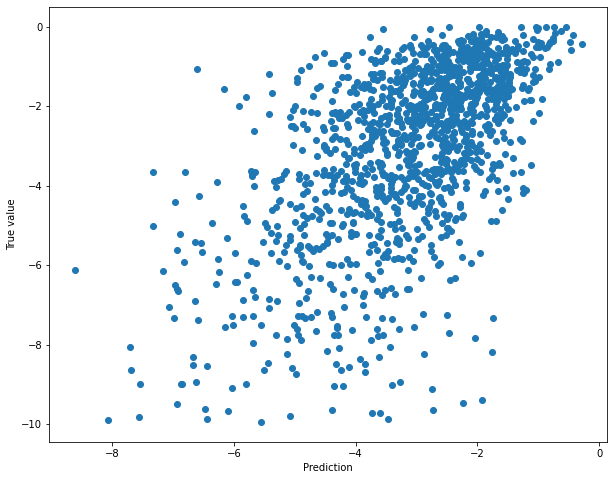

In [57]:
plt.figure(figsize=(10, 8))
plt.plot(reg.predict(X_test), y_test, 'o')
plt.xlabel('Prediction')
plt.ylabel('True value')

# One Hot Encoding

In [58]:
X = df_store_sku[['SKU', 'Store', 'ClassId', 'CategoryId', 'ClusterId', 'StoreAge', 'StoreCity', 'Q1_Qty', 'Q1_Price', 'Q1_Elasticity', 'Q1_Ttest']]
y = df_store_sku['Elasticity']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [61]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [63]:
categorical = ['ClassId', 'CategoryId', 'ClusterId', 'StoreAge', 'StoreCity']

In [64]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('random-forest', RandomForestRegressor())
])

model = pipeline.fit(X_train, y_train)

In [65]:
mean_squared_error(y_test, model.predict(X_test))

4.404680863351394

Text(0, 0.5, 'True value')

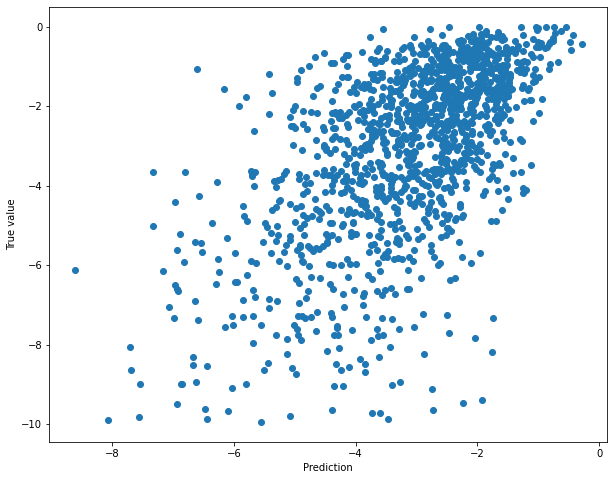

In [66]:
plt.figure(figsize=(10, 8))
plt.plot(reg.predict(X_test), y_test, 'o')
plt.xlabel('Prediction')
plt.ylabel('True value')